# Amperon Data Engineering Take Home Assignment

In [6]:
import pandas as pd
from sqlalchemy import create_engine
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
# --- Database Connection Details
PGUSER = os.environ.get('PGUSER', 'postgres')
PGPASSWORD = os.environ.get('PGPASSWORD', 'postgres')
# FORCE 'localhost'
PGHOST = 'localhost'
PGPORT = os.environ.get('PGPORT', '5432')
PGDATABASE = os.environ.get('PGDATABASE', 'tomorrow')

DB_URL = f"postgresql://{PGUSER}:{PGPASSWORD}@{PGHOST}:{PGPORT}/{PGDATABASE}"
engine = create_engine(DB_URL)

# The success message should now show localhost:
print(f"Connected to database: {PGDATABASE} on {PGHOST}")

# Set visualization style
sns.set_style("whitegrid")

Connected to database: tomorrow on localhost


In [8]:
# Check row count
row_count = pd.read_sql("SELECT COUNT(*) FROM weather_data", engine).iloc[0, 0]
print(f"Total rows in weather_data: {row_count}")

# Inspect sample data
df_sample = pd.read_sql("SELECT * FROM weather_data LIMIT 5", engine)
print("\nSample Data:")
print(df_sample.head())

# Inspect data types
print("\nData Types:")
df_sample.info()

Total rows in weather_data: 120

Sample Data:
   id              ingestion_timestamp  latitude  longitude  \
0   1 2025-12-16 12:41:15.697527+00:00     25.86     -97.42   
1   2 2025-12-16 12:41:15.697527+00:00     25.86     -97.42   
2   3 2025-12-16 12:41:15.697527+00:00     25.86     -97.42   
3   4 2025-12-16 12:41:15.697527+00:00     25.86     -97.42   
4   5 2025-12-16 12:41:15.697527+00:00     25.86     -97.42   

                 time_stamp  is_forecast  temperature  wind_speed  humidity  \
0 2025-12-16 12:00:00+00:00        False         54.2         5.2      94.0   
1 2025-12-16 13:00:00+00:00         True         52.2         3.7      92.0   
2 2025-12-16 14:00:00+00:00         True         53.5         4.9      92.0   
3 2025-12-16 15:00:00+00:00         True         57.5         4.2      87.0   
4 2025-12-16 16:00:00+00:00         True         61.8         1.3      83.0   

  precipitation_type  
0               None  
1               None  
2               None  
3       

In [9]:
# --- Q1: Get the latest non-forecasted observation for each unique location ---
# This is a critical data transformation step (T in ELT)
query_q1 = """
SELECT DISTINCT ON (latitude, longitude)
    latitude,
    longitude,
    time_stamp,
    temperature,
    wind_speed
FROM
    weather_data
WHERE
    is_forecast = FALSE
ORDER BY
    latitude, longitude, time_stamp DESC;
"""

df_latest_obs = pd.read_sql(query_q1, engine)

print(f"Q1 Results: Found {len(df_latest_obs)} latest observations.")
print(df_latest_obs)

Q1 Results: Found 1 latest observations.
   latitude  longitude                time_stamp  temperature  wind_speed
0     25.86     -97.42 2025-12-16 12:00:00+00:00         54.2         5.2


In [10]:
# --- Q2: Get the hourly temperature time series for a single location (e.g., the first one) ---
target_lat = df_latest_obs['latitude'].iloc[0]
target_lon = df_latest_obs['longitude'].iloc[0]

# Filter for the last 24 hours of history AND all available forecast data
query_q2 = f"""
SELECT
    time_stamp,
    temperature,
    is_forecast
FROM
    weather_data
WHERE
    latitude = {target_lat} AND longitude = {target_lon}
ORDER BY
    time_stamp ASC;
"""

df_timeseries = pd.read_sql(query_q2, engine, parse_dates=['time_stamp'])

print(f"Q2 Results: Found {len(df_timeseries)} time-series records for location ({target_lat}, {target_lon}).")
df_timeseries.head()

Q2 Results: Found 120 time-series records for location (25.86, -97.42).


,time_stamp,temperature,is_forecast
0,2025-12-16 12:00:00+00:00,54.2,False
1,2025-12-16 13:00:00+00:00,52.2,True
2,2025-12-16 14:00:00+00:00,53.5,True
3,2025-12-16 15:00:00+00:00,57.5,True
4,2025-12-16 16:00:00+00:00,61.8,True


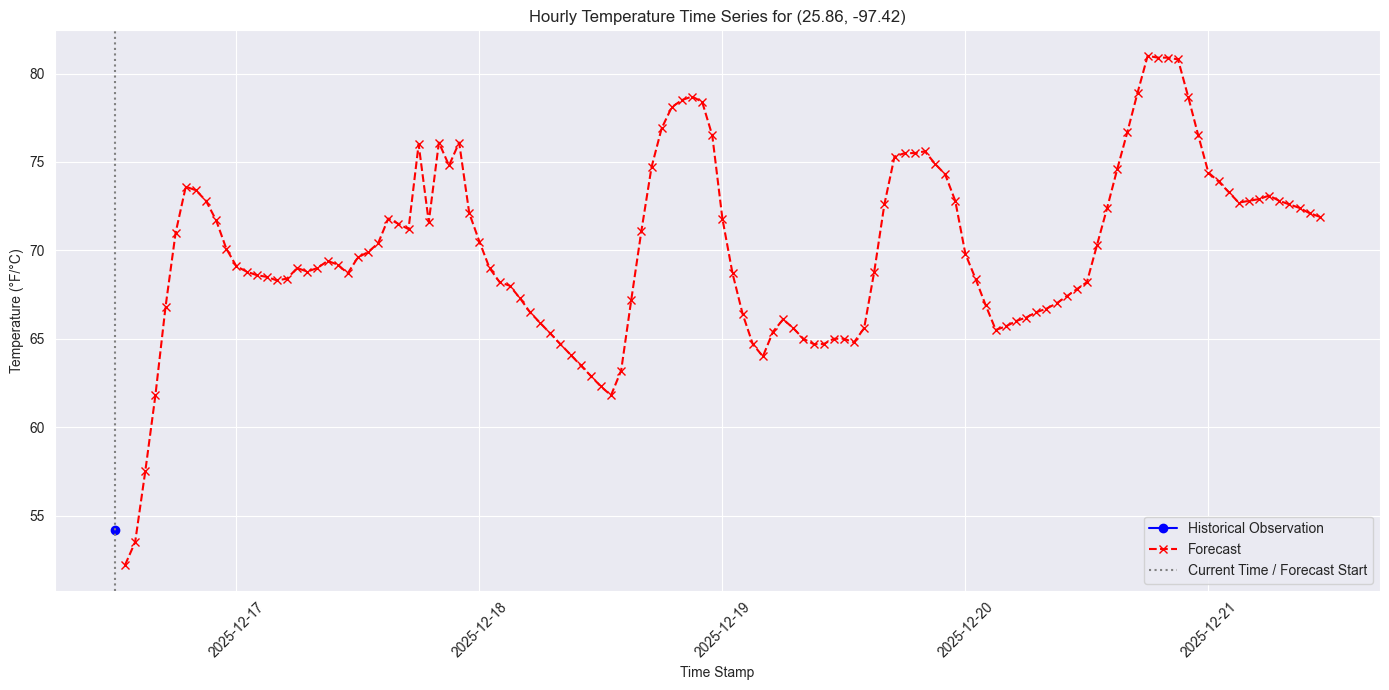

In [11]:
# --- Visualization of Q2 Results (Time Series Forecast/History) ---

plt.figure(figsize=(14, 7))

# Separate historical
df_history = df_timeseries[df_timeseries['is_forecast'] == False]
df_forecast = df_timeseries[df_timeseries['is_forecast'] == True]

# Plot historical data
plt.plot(df_history['time_stamp'], df_history['temperature'],
         label='Historical Observation', marker='o', linestyle='-', color='blue')

# Plot forecast data
plt.plot(df_forecast['time_stamp'], df_forecast['temperature'],
         label='Forecast', marker='x', linestyle='--', color='red')

# Find the point where forecast begins
if not df_history.empty and not df_forecast.empty:
    last_history_time = df_history['time_stamp'].max()
    plt.axvline(x=last_history_time, color='gray', linestyle=':', label='Current Time / Forecast Start')

plt.title(f'Hourly Temperature Time Series for ({target_lat}, {target_lon})')
plt.xlabel('Time Stamp')
plt.ylabel('Temperature (°F/°C)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Loaded 120 hourly data points for 25.86, -97.42


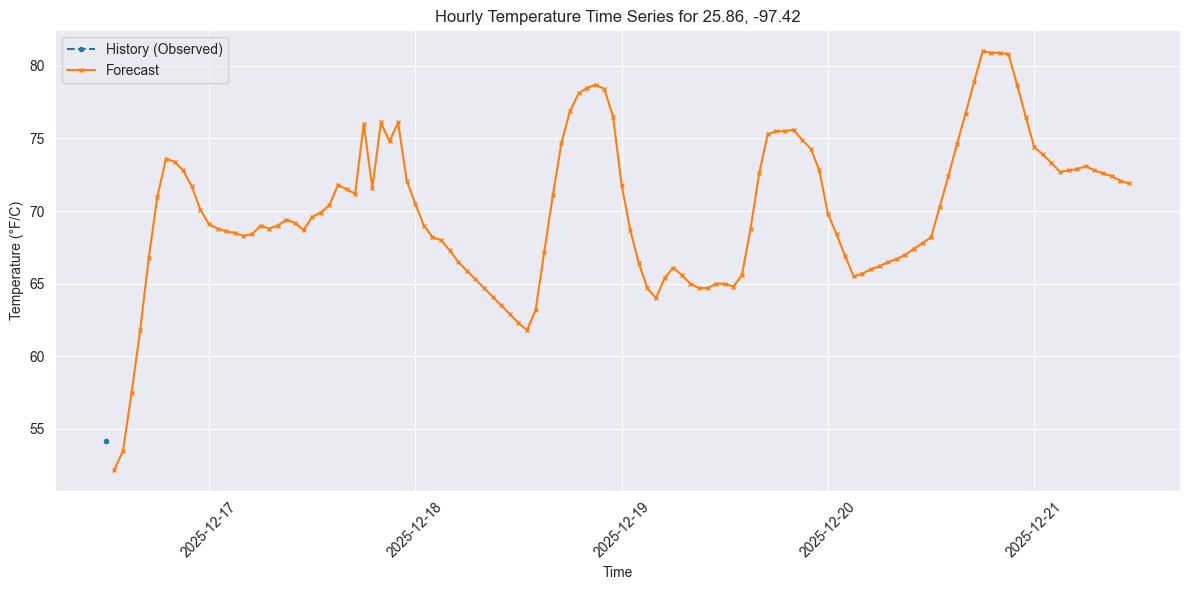

In [12]:

# Select one location to plot (e.g., the first one: 25.86, -97.42)
TARGET_LAT = 25.86
TARGET_LON = -97.42

Q2_SQL = f"""
SELECT
    time_stamp,
    temperature,
    is_forecast
FROM
    weather_data
WHERE
    latitude = {TARGET_LAT} AND longitude = {TARGET_LON}
ORDER BY
    time_stamp;
"""

df_timeseries = pd.read_sql(Q2_SQL, engine)
print(f"Loaded {len(df_timeseries)} hourly data points for {TARGET_LAT}, {TARGET_LON}")

# Plot the time series
plt.figure(figsize=(12, 6))

# Separate History and Forecast for clear visualization
df_history = df_timeseries[df_timeseries['is_forecast'] == False]
df_forecast = df_timeseries[df_timeseries['is_forecast'] == True]

plt.plot(df_history['time_stamp'], df_history['temperature'],
         label='History (Observed)', marker='o', linestyle='--', markersize=3)

plt.plot(df_forecast['time_stamp'], df_forecast['temperature'],
         label='Forecast', marker='x', linestyle='-', markersize=3)

plt.title(f'Hourly Temperature Time Series for {TARGET_LAT}, {TARGET_LON}')
plt.xlabel('Time')
plt.ylabel('Temperature (°F/C)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [14]:
import pandas as pd
from sqlalchemy import create_engine


# Query 1: Total number of unique records
TOTAL_COUNT_SQL = """
SELECT COUNT(*) FROM weather_data;
"""

# Query 2: The latest timestamp recorded in the database
LATEST_TIMESTAMP_SQL = """
SELECT MAX(time_stamp) FROM weather_data;
"""

df_count = pd.read_sql(TOTAL_COUNT_SQL, engine)
df_latest_ts = pd.read_sql(LATEST_TIMESTAMP_SQL, engine)

print("--- Data Integrity Check ---")
print(f"Total Unique Records in DB: {df_count.iloc[0, 0]}")
print(f"Latest Timestamp in DB: {df_latest_ts.iloc[0, 0]}")

--- Data Integrity Check ---
Total Unique Records in DB: 120
Latest Timestamp in DB: 2025-12-21 11:00:00+00:00
